In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
%matplotlib inline

In [ ]:
# search bounds of the domain 
# each element in the inner list corresponds to one dimension
bounds = np.array([[-1.0, 2.0]])
# observation noise
noise = 0.2
# objective function used to reveal observations upon sampling, optionally with noise
def f(x, noise=0):
    # use * to unpack the tuple from x.shape when passing into np.random.randn
    return -np.sin(3*x) - x**2 + 0.7*x + noise*np.random.randn(*x.shape)

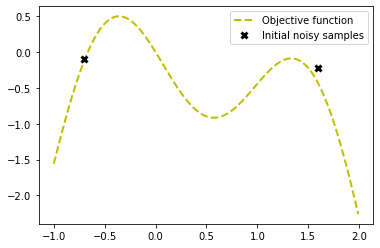

In [ ]:
# initial observations upon initiation
X_init = np.array([[-0.7], [1.6]])
Y_init = f(X_init, noise=noise)
# dense grid of points within bounds used for plotting
X_plot = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
# noise-free objective function values used for plotting
Y_plot = f(X_plot, noise=0)
# Plot objective function with noisy observations
plt.plot(X_plot, Y_plot, 'y--', lw=2, label='Objective function')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial noisy samples')
plt.legend()

In [ ]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    # posterior mean and sd at proposed location
    mu, sigma = gpr.predict(X, return_std=True)
    # posterior mean at observed location
    mu_sample = gpr.predict(X_sample)
    # reshape to make one sd per each proposed location
    sigma = sigma.reshape(-1, 1)
    # use maximal posterior mean instead of actual observations due to noise
    mu_sample_opt = np.max(mu_sample)
    # ignore divide by zero warning if any
    with np.errstate(divide='warn'):
        # calculate ei if sd>0
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        # set zero if sd=0
        ei[sigma == 0.0] = 0.0
    return ei

In [ ]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).na
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
    Returns:
        Location of the acquisition function maximum.
    '''
    # dimension of search domain
    dim = X_sample.shape[1]
    # temporary running best minimum
    min_val = 1
    # temporary location of best minimum
    min_x = None

    # map an arbitrary location to the negative of acquisition function
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    # iterate through n_restart different random points and return most promising result
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        # use off-the-shelf solver based on approximate second order derivative
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        # replace running optimum if any
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [ ]:
def plot_approximation(gpr, X_plot, Y_plot, X_sample, Y_sample, X_next=None, show_legend=False):
    # get posterior mean and sd across teh dense grid
    mu, std = gpr.predict(X_plot, return_std=True)
    # plot mean and 95% confidence interval
    plt.fill_between(X_plot.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X_plot, Y_plot, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X_plot, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    # plot the next sampling location as vertical line
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X_plot, acq_value, X_next, show_legend=False):
    # plot the value of acquisition function across the dense grid
    plt.plot(X_plot, acq_value, 'r-', lw=1, label='Acquisition function')
    # plot the next sampling location as vertical line
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))
    # focus on sampled queried by the optimization policy
    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    # distance between consecutive sampling locations
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    # best observed value until the current time point
    y_max = np.maximum.accumulate(y)
    # plot the distance between consecutive sampling locations
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')
    # plot the evolution of observed maximum so far
    plt.subplot(1, 2, 2)
    plt.plot(r, y_max, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

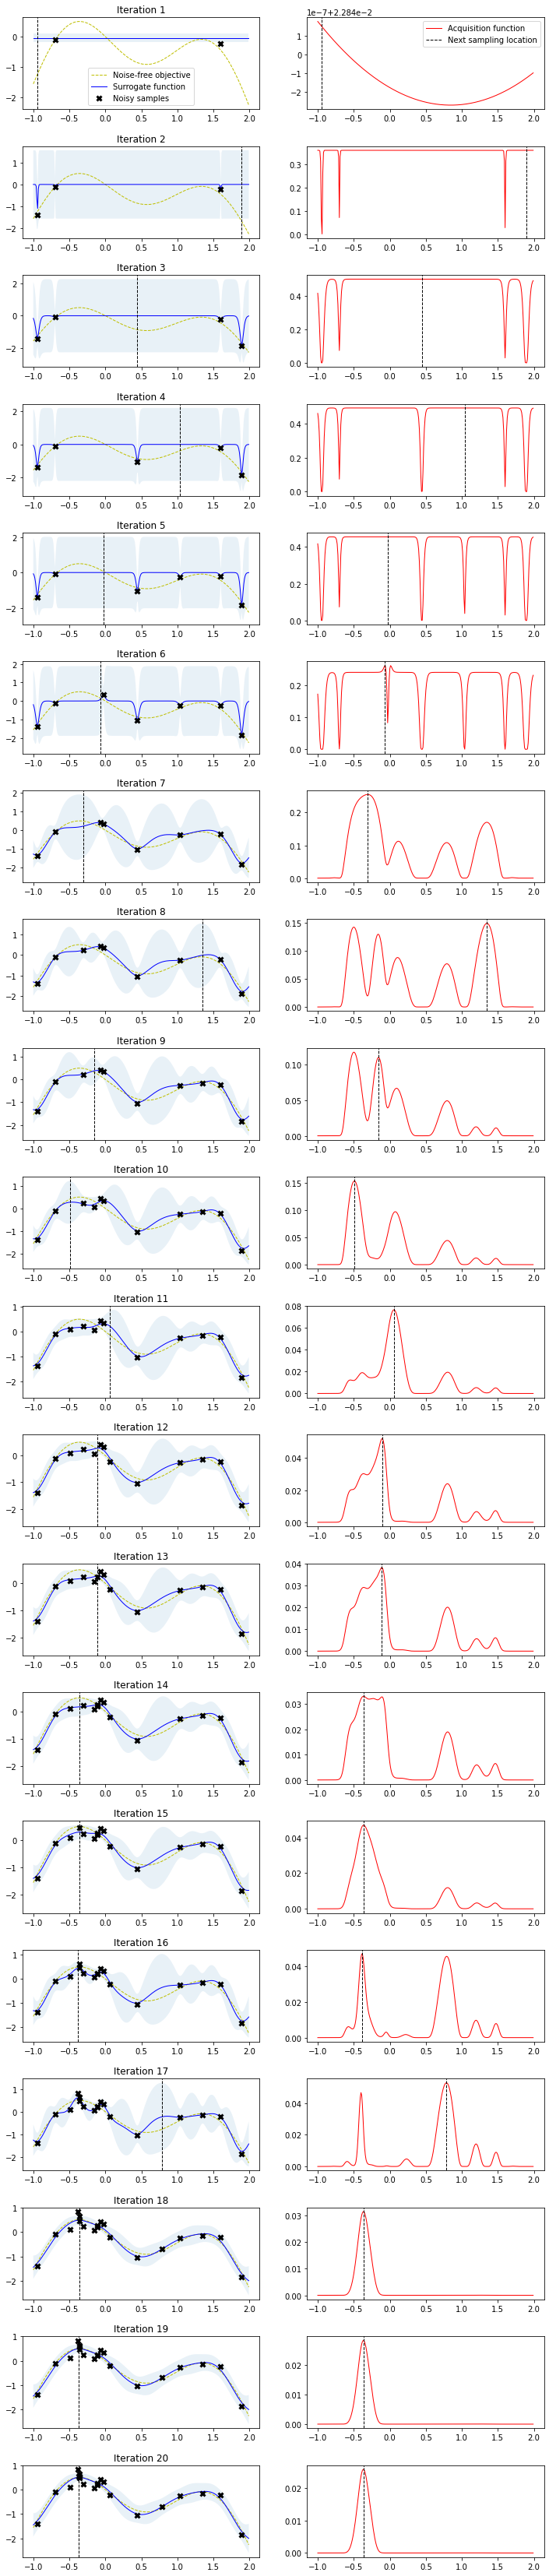

In [ ]:
# Gaussian process with Matern kernel as surrogate model
# kernel parameters could be optimized using MLE
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
# specify observation noise term, assumed to be known in advance
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
# initial samples before optimization starts
X_sample = X_init
Y_sample = Y_init
# number of optimization iterations
n_iter = 20
# specify figure size
plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)
# start of optimization
for i in range(n_iter):
    # update GP posterior given existing samples
    gpr.fit(X_sample, Y_sample)
    # obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    # obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    # plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X_plot, Y_plot, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')
    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X_plot, expected_improvement(X_plot, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    # append the additional sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

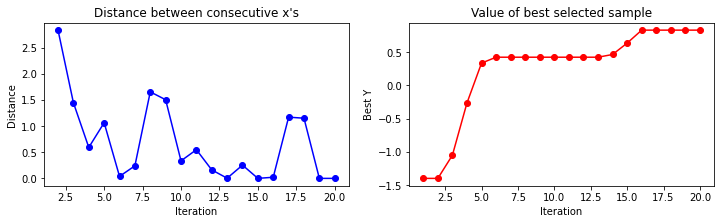

In [ ]:
plot_convergence(X_sample, Y_sample, n_init=X_init.shape[0])

## scikit-optimize

In [ ]:
!pip install scikit-optimize

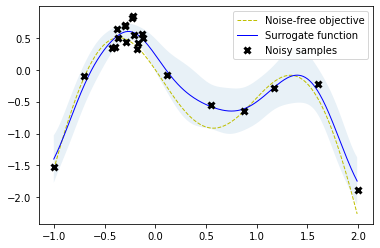

In [ ]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
g = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
# start BO
r = gp_minimize(func=lambda x: -f(np.array(x), noise=noise)[0], # function to minimize
                dimensions=bounds.tolist(),    # search bounds
                base_estimator=gpr, # GP prior
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=n_iter,    fo
                # number of iterations
                n_initial_points=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())
# fit GP model to samples for plotting
gpr.fit(r.x_iters, -r.func_vals)
# Plot the fitted model and the noisy samples
plot_approximation(gpr, X_plot, Y_plot, r.x_iters, -r.func_vals, show_legend=True)

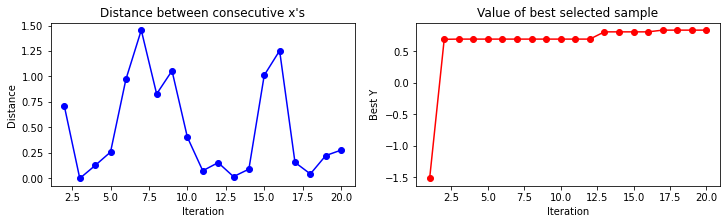

In [ ]:
plot_convergence(np.array(r.x_iters), -r.func_vals)